# Algoritmus 2D Szenzor optim√°lis poz√≠ci√≥j√°ra

Vegy√ºnk egy 2D h≈ët√©rk√©pet kiindul√°sk√©ppen.

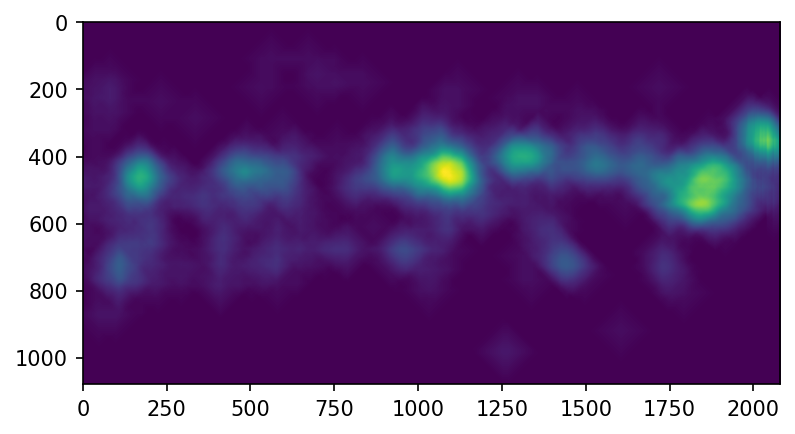

In [1]:
%matplotlib inline

import numpy as np
from string import ascii_lowercase
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
import matplotlib as mpl
import seaborn as sns
from scipy import ndimage as ndi
from scipy.stats import mode
from skimage.feature import peak_local_max
from tqdm import tqdm
from place_me import optimize_v1, optimize_v2, optimize_v3

mpl.rcParams['figure.dpi'] = 150

data = np.loadtxt('data/heatmap2.txt')
data = 255 * data / data.max()
data = data[:, 1760:3840]
plt.imshow(data);

A h≈ët√©rk√©pen kiv√°lasztunk $n$ darab lok√°lis maximum helyet, amelyen elhelyez√ºnk $R$ sugar√∫ k√∂r√∂ket, ahol $n$ √©s $R$ az adott k√∂rnyezethez v√°lasztott. (P√©lda: $n$-t az alkalmaz√°st haszn√°l√≥ szem√©lyek sz√°m√°b√≥l kapjuk, $R$-t pedig √∫gy v√°lasztjuk, hogy a val√≥s√°gbeli m√©rete nagyj√°b√≥l az emberi k√©zzel azonos legyen). A h≈ët√©rk√©p nem determinisztikus, hanem val√≥sz√≠n≈±s√©gi jelleg≈±, vagyis a gener√°lt k√∂r√∂k pontos poz√≠ci√≥ja ingadozik: a h≈ët√©rk√©pen nagyobb √©rt√©ken nagyobb val√≥sz√≠n≈±s√©ggel tart√≥zkodik. A k√∂r√∂k nem fedhetnek egym√°sba. Az al√°bbi k√©p egy $n = 6$ √©s $R = 40\,pixel$ fel√°ll√°st mutat.

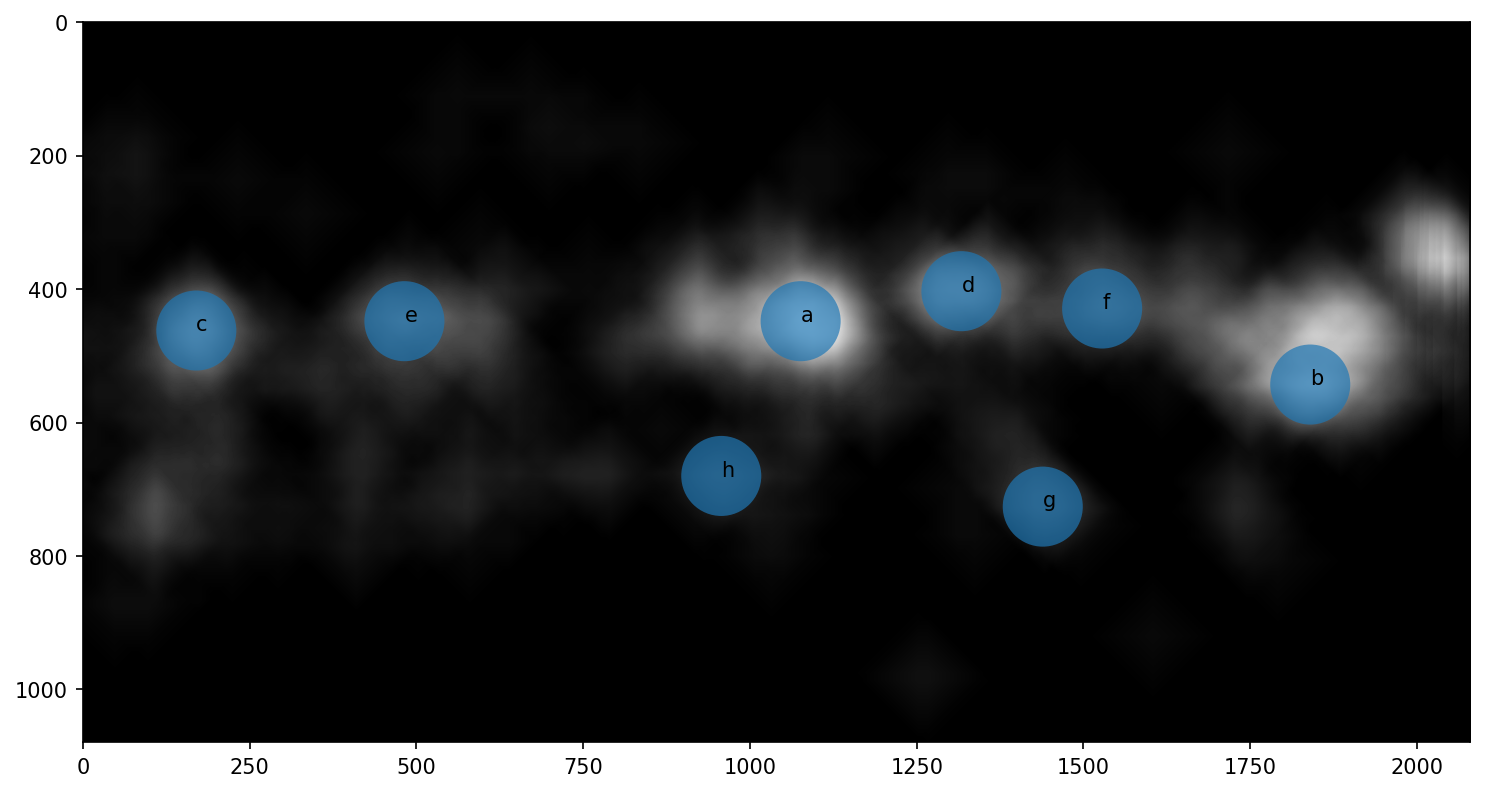

In [2]:
CIRCLE_RADIUS = 60
NUM_PEAKS = 8

image_max = ndi.maximum_filter(data, size=20, mode='constant')

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=NUM_PEAKS)
LETTERS = list(ascii_lowercase)[:NUM_PEAKS]

pairs = {l: p for l, p in zip(LETTERS, peaks)}

def plot_from_optimal_coords(data, peaks, arr=None, covs=None):
    colors = ["yellow", "red", "green"]
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.imshow(data, cmap=plt.cm.gray)
    ax.autoscale(False)
    if arr is not None:
        for i in range(0, len(arr) - 1, 2):
            format_string = f"{colors[i // 2][0]}x"
            ax.plot(arr[i], arr[i + 1], format_string, markersize=25, markeredgewidth=3)       

    for i, (y, x) in enumerate(peaks):
        ax.text(x, y, LETTERS[i])
        circ = Circle((x, y), CIRCLE_RADIUS, alpha=0.7)
        ax.add_patch(circ)

    if covs is not None:
        for (k, sensor) in enumerate(covs):
            for (letter, data) in sensor.items():
                y, x = pairs[letter]
                for j in range(0, len(data) - 1, 2):
                    arc =  Arc((x, y),
                               CIRCLE_RADIUS * 2 + k * 15,
                               CIRCLE_RADIUS * 2 + k * 15,
                               0,
                               np.rad2deg(data[j]),
                               np.rad2deg(data[j + 1]),
                               color=colors[k],
                               alpha=1,
                               lw=2 + k
                              )
                    ax.add_patch(arc)

        

    fig.tight_layout()

    plt.show()

plot_from_optimal_coords(data, peaks)

Minden szenzor a h≈ët√©rk√©p ker√ºlete ment√©n mozoghat. Egy szenzor eset√©n a lefedetts√©get √∫gy defini√°ljuk, hogy:
  - a lehet≈ë legt√∂bb k√∂rt l√°ssuk
  - a k√∂r√∂kb≈ël l√°tott ker√ºlet szeletek √∂sszege a lehet≈ë legnagyobb


√öjabb szenzorok hozz√°ad√°s√°n√°l egy adott k√∂rn√©l a m√°r kor√°bban lefedett ter√ºleteket nem vessz√ºk figyelembe - mivel ez nem hordoz √∫j inform√°ci√≥t. A folyamat az, hogy addig adunk hozz√° √∫j szenzorokat, am√≠g minden k√∂r l√°that√≥ legal√°bb egy szenzor sz√°m√°ra. A val√≥sz√≠n≈±s√©gi jelleg miatt ezt a szimul√°ci√≥t kell≈ëen sokszor futtatva megkapjuk, hogy mik lesznek az optim√°lis szenzor poz√≠ci√≥k.

Form√°lisan:

Legyen $I(x) = 1$ ha $x > 0$, k√ºl√∂nben $0$, √∫n. indik√°tor f√ºggv√©ny, tov√°bb√° jel√∂lje egy adott $i$ objektum bel√°tott r√©sz√©t $L_{i} = \frac{\sum x_i}{2\pi R}$. Ekkor $n$ darab objektum eset√©n az $LF$ teljes lefedetts√©get a k√∂vetkez≈ëk√©ppen defini√°ljuk:
<center>
$LF = \sum_{i=1}^{n} (I(x_i) + L_i(x))$
</center>




A lentebbi √°br√°k ezzel a s√∫lyf√ºggv√©nnyel sz√°molt szimul√°ci√≥k eseteit mutatj√°k, ahol piros, s√°rga √©s z√∂ld markerek mutatj√°k az optim√°lis szenzor poz√≠ci√≥kat. Az al√°bbi p√©ld√°kban k√ºl√∂nb√∂z≈ë sz√°m√∫ szenzorra futtatjuk v√©gig a szimul√°ci√≥kat, illetve az egyikn√©l 200-szor futtatjuk v√©gig kiss√© k√ºl√∂nb√∂z≈ë poz√≠ci√≥j√∫ k√∂r√∂k√∂n, majd a KDE plotr√≥l a maximum √©rt√©ket v√°lasztjuk poz√≠ci√≥k√©nt, √©s azt √°br√°zoljuk.

#### Szimul√°ci√≥ 1 szenzorral:

In [ ]:
%env RUST_LOG=1
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2880,
    'pixel_step': 20,
}
res, covs = optimize_v1(*arr.T, LETTERS, [0.0,  940.0, 1080.0, 930.0], **options)
plot_from_optimal_coords(data, peaks, res, covs)

#### Szimul√°ci√≥ 2 szenzorral:

env: RUST_LOG=1

üéØ covered 85.29414759976245% (13.647063615961994/16)
‚úÖ optimal positions [
    Point {
        x: 1140.0,
        y: 1080.0,
    },
    Point {
        x: 840.0,
        y: 0.0,
    },
]


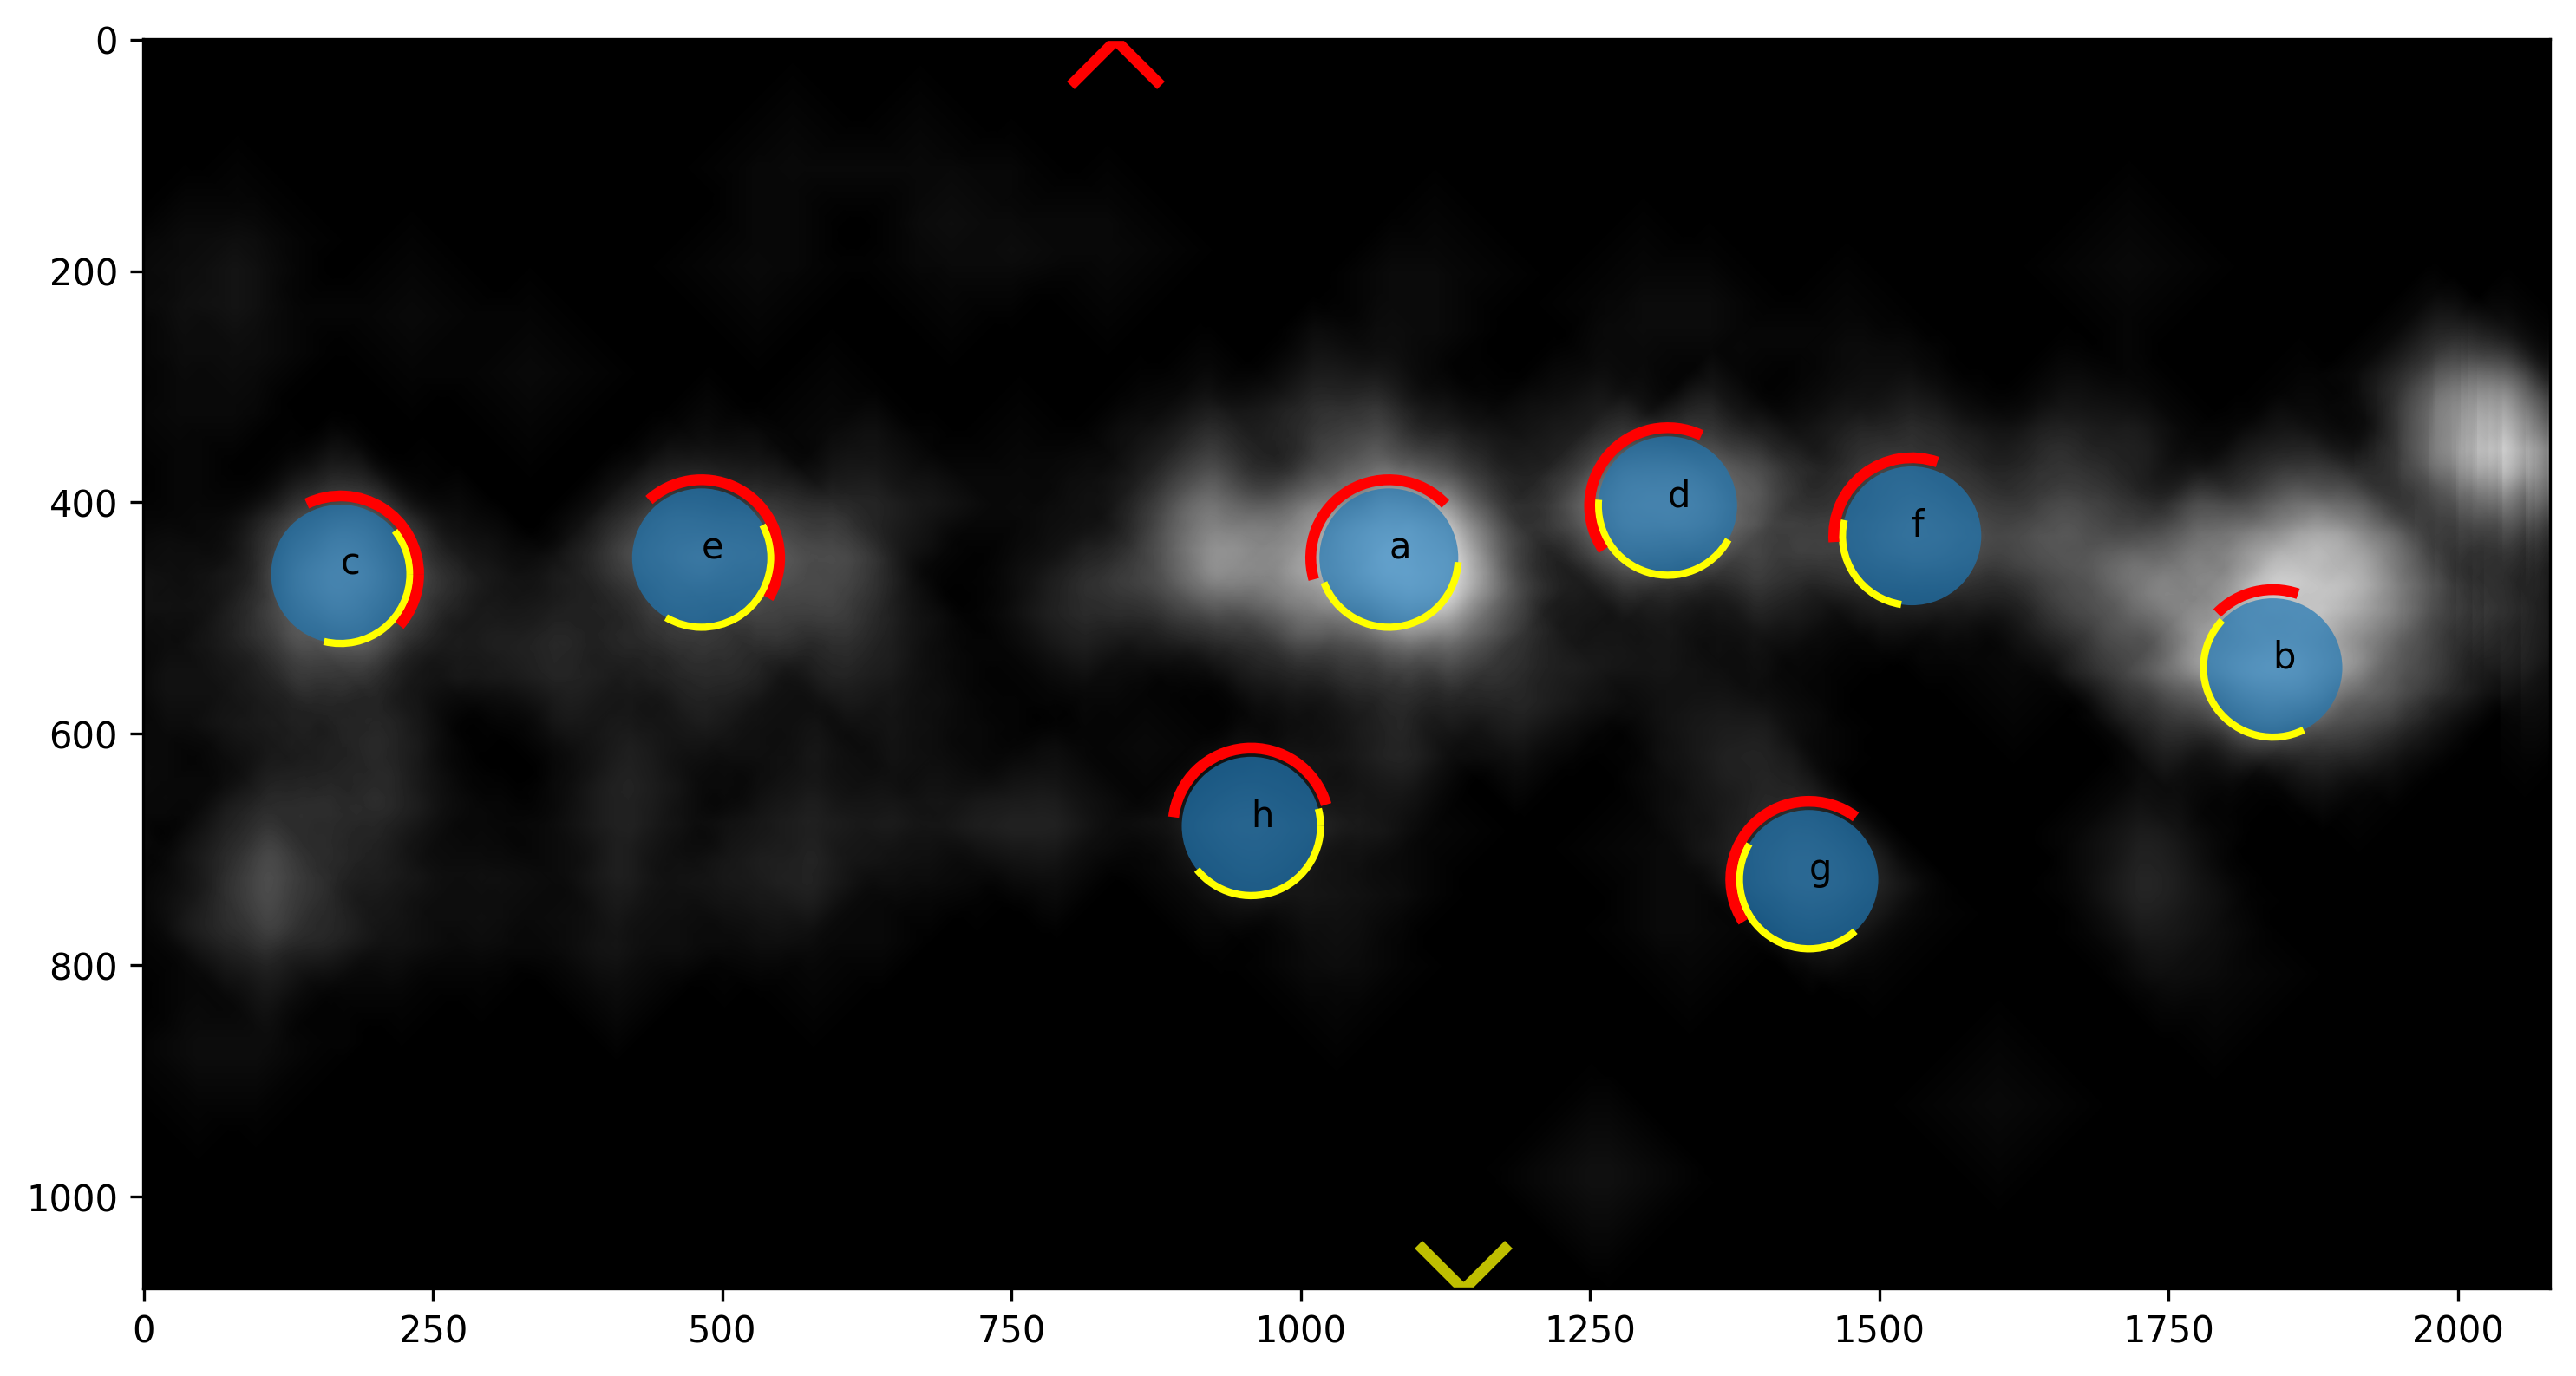

In [15]:
%env RUST_LOG=1
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2880,
    'pixel_step': 10,
}
res, covs = optimize_v2(*arr.T, LETTERS, **options)
plot_from_optimal_coords(data, peaks, res, covs)

In [16]:
%env RUST_LOG=0

NUM_OF_SIM = 50
r = np.array([])

for i in tqdm(range(NUM_OF_SIM)):
    peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=NUM_PEAKS)
    peaks = peaks + np.random.normal(0, CIRCLE_RADIUS / 4, size=peaks.shape)
    arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
    options = {
        'width': data.shape[1],
        'height': data.shape[0],
        'resolution': 2280,
        'pixel_step': 20,
    }
    res, _ = optimize_v2(*arr.T, LETTERS, **options)
    r = np.append(r, res)

env: RUST_LOG=0


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [02:27<00:00,  2.95s/it]


In [17]:
res = np.array(np.array_split(r, NUM_OF_SIM))

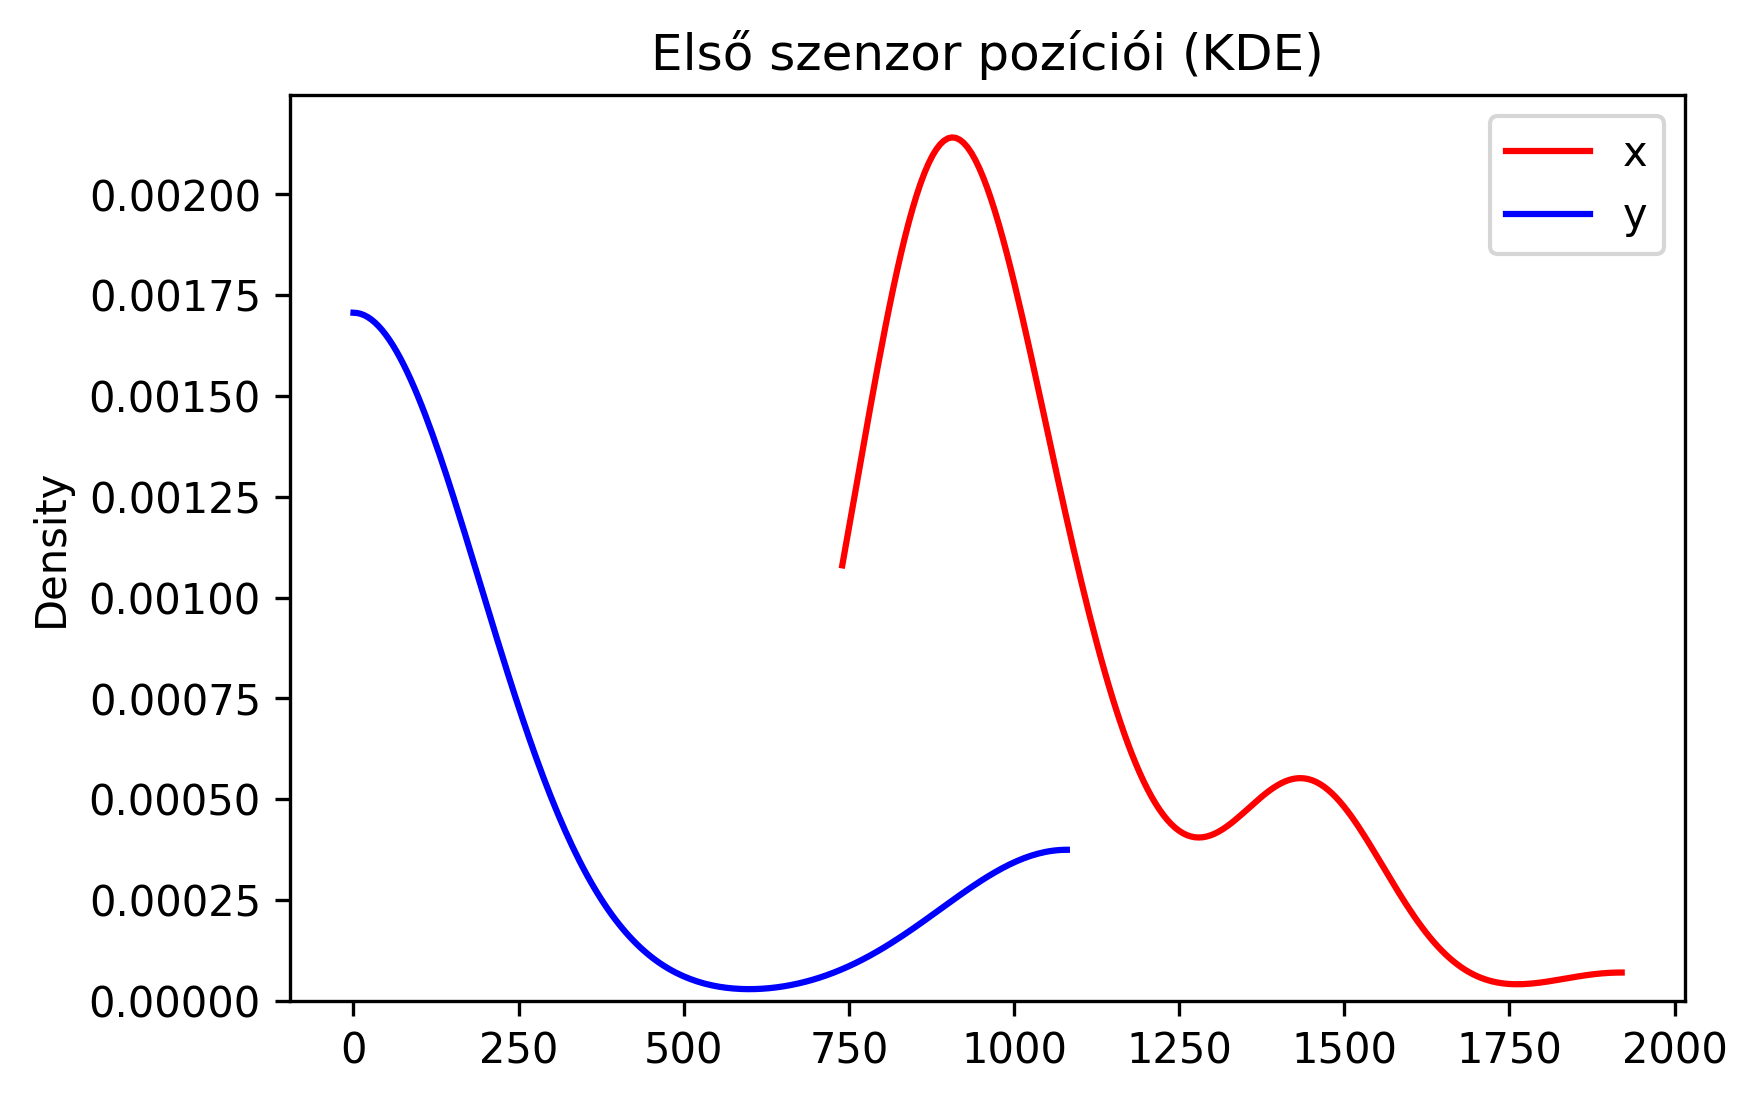

In [18]:
# First sensor
sns.kdeplot(res[:,0], color='red', cut=0, label="x")
sns.kdeplot(res[:,1], color='blue', cut=0, label="y")
plt.title("Els≈ë szenzor poz√≠ci√≥i (KDE)")
plt.legend();

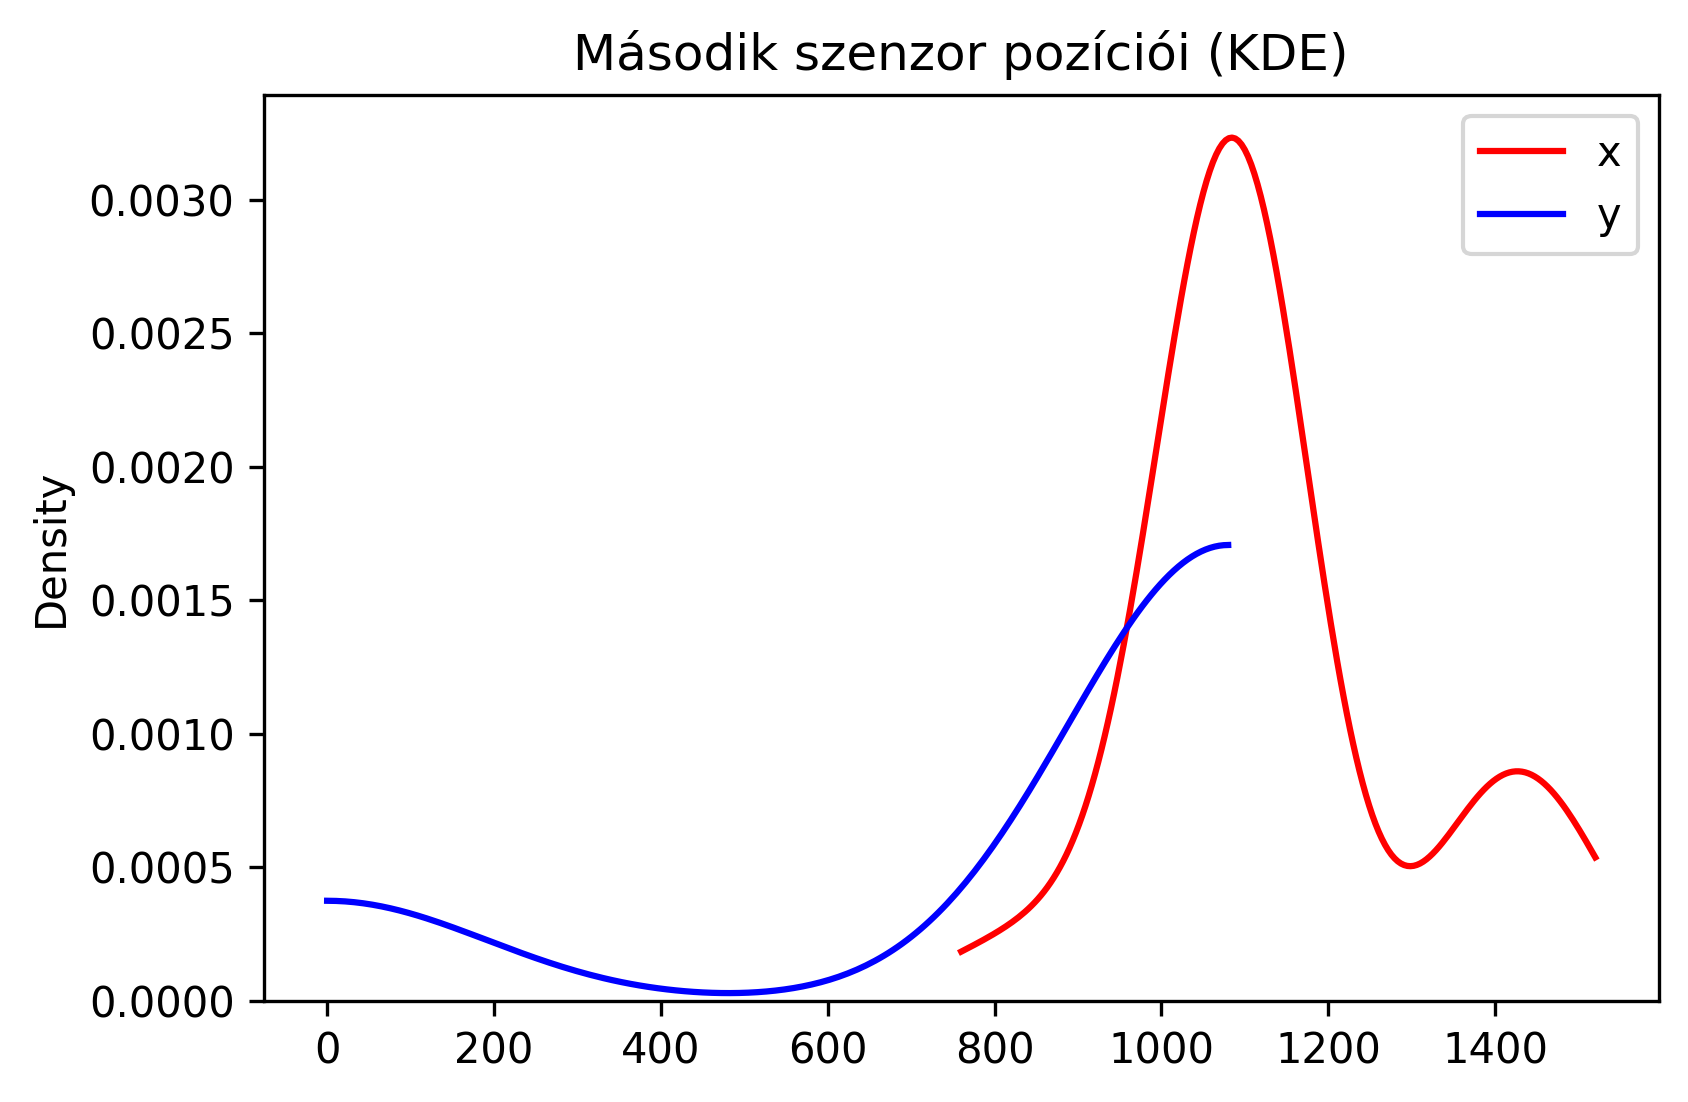

In [19]:
# Second sensor
sns.kdeplot(res[:,2], color='red', cut=0, label="x")
sns.kdeplot(res[:,3], color='blue', cut=0, label="y")
plt.title("M√°sodik szenzor poz√≠ci√≥i (KDE)")
plt.legend();

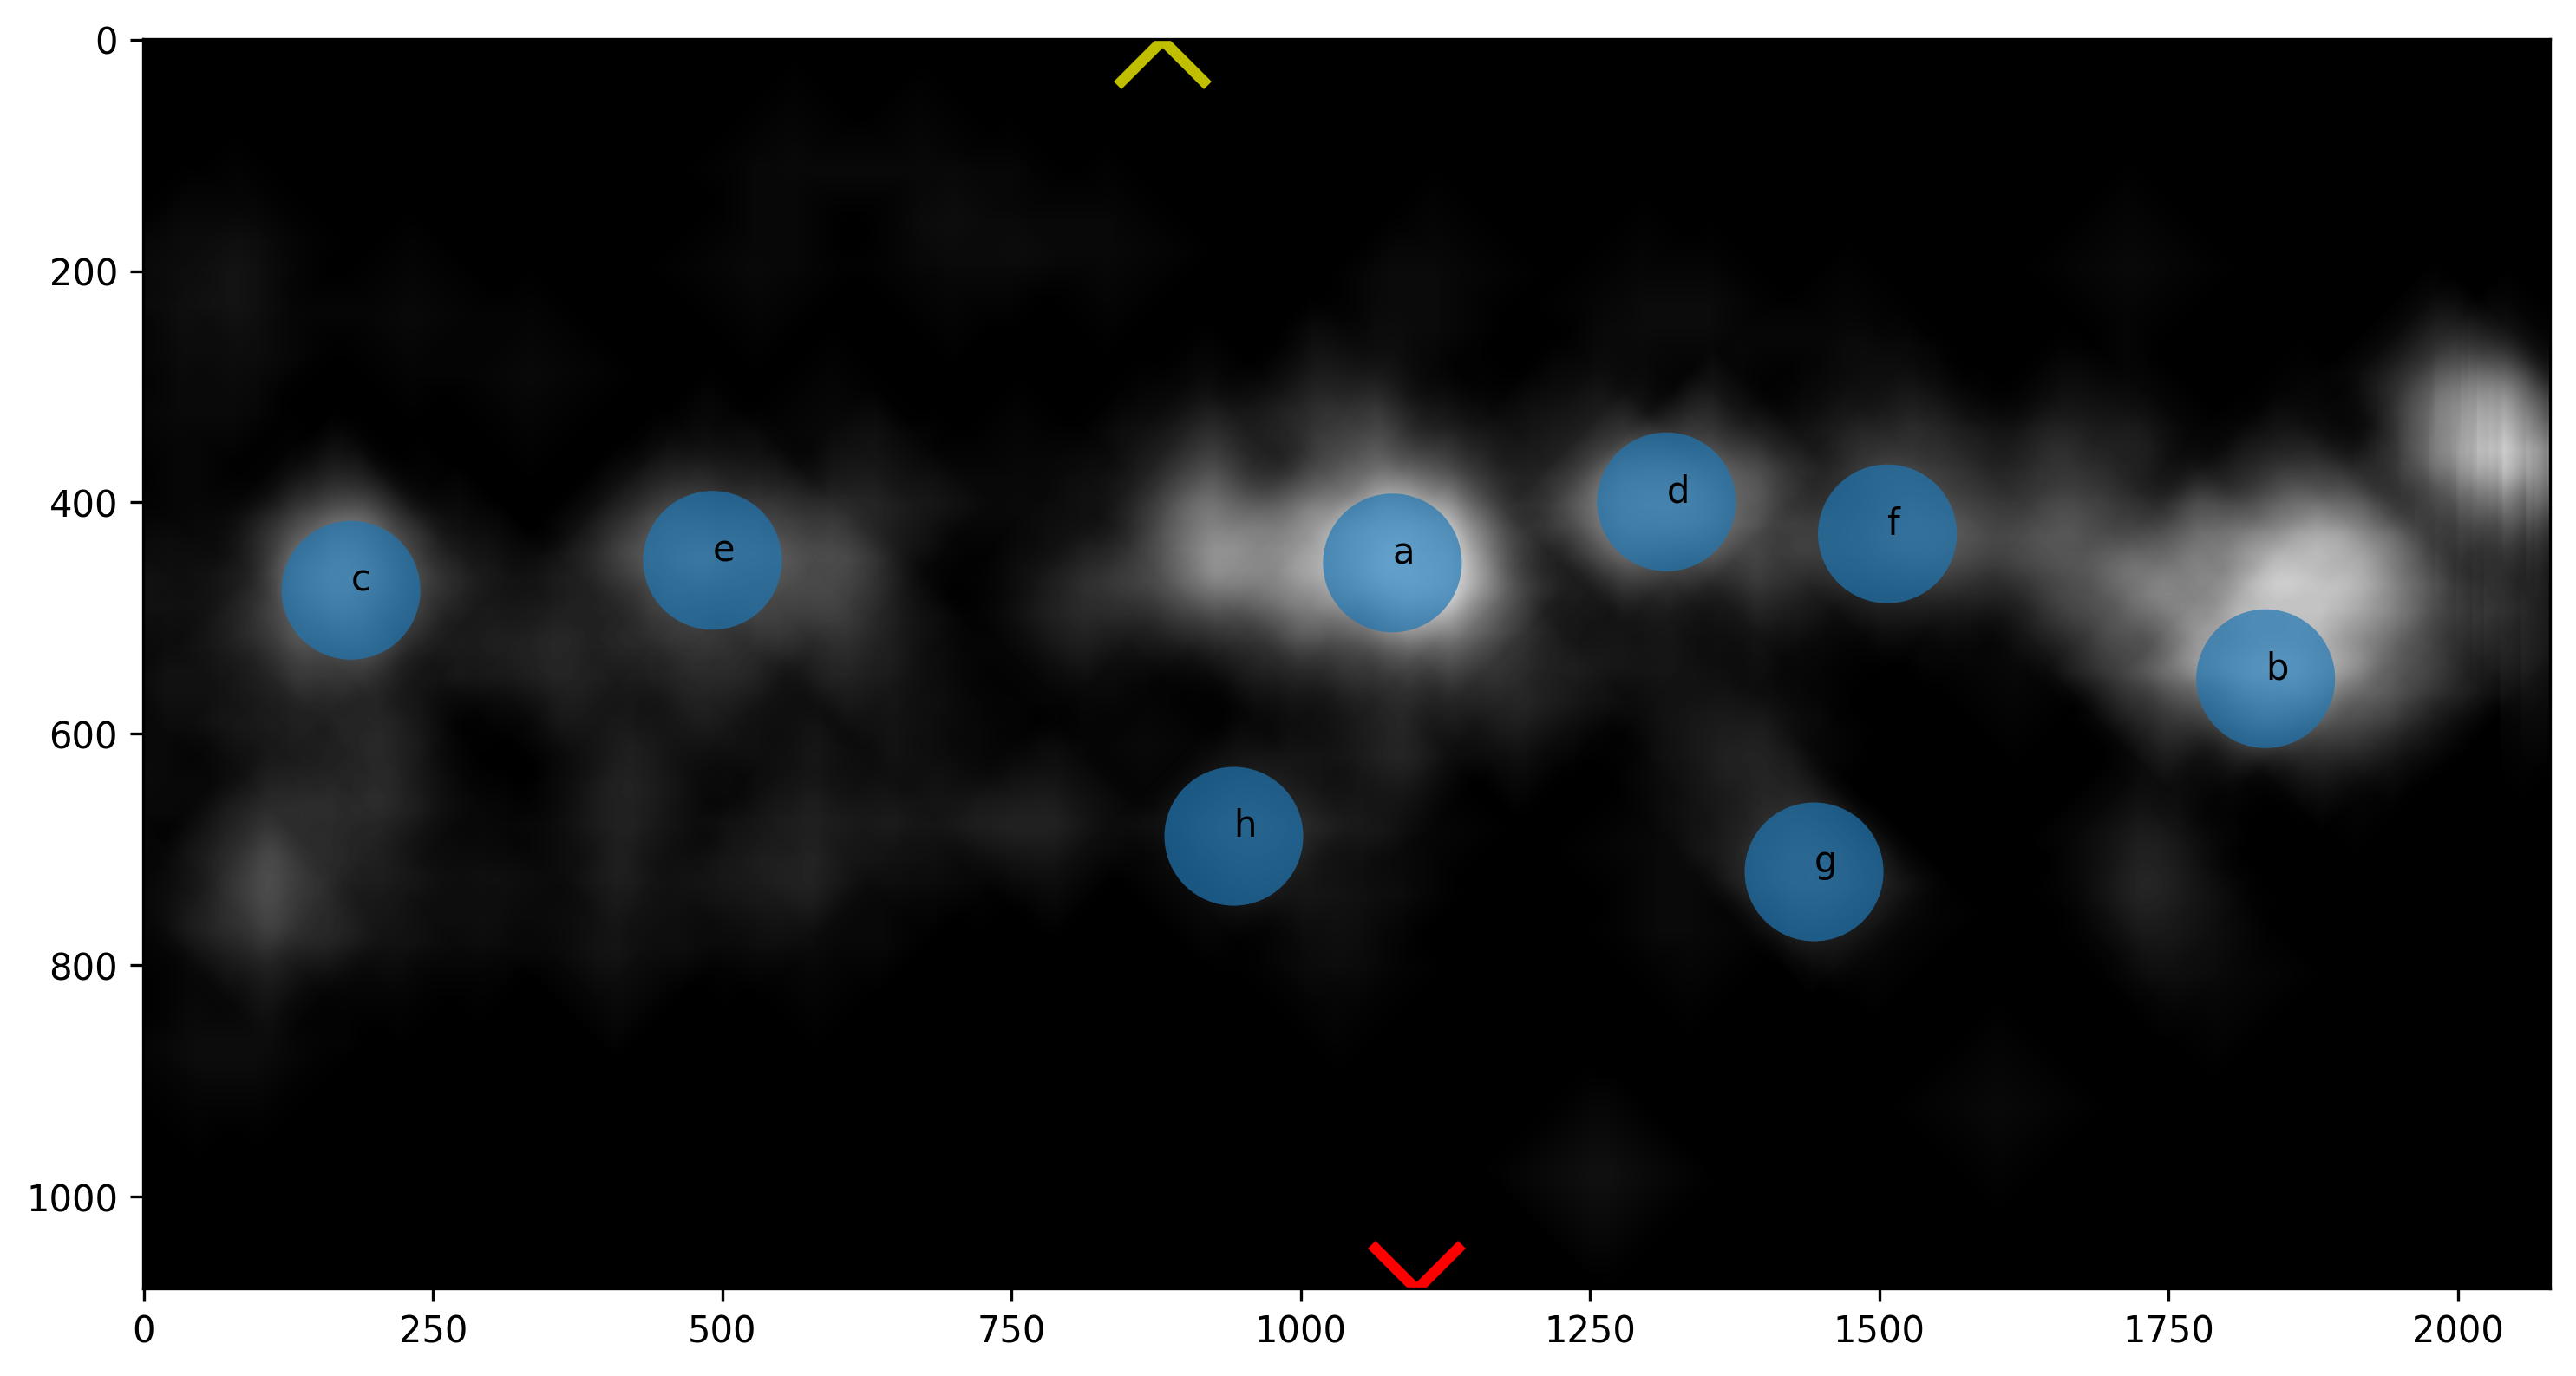

In [20]:
plot_from_optimal_coords(data, peaks, mode(res, axis=0).mode[0])

#### Szimul√°ci√≥ h√°rom szenzorral:

env: RUST_LOG=1

üéØ covered 94.27833941066461% (15.084534305706338/16)
‚úÖ optimal positions [
    Point {
        x: 940.0,
        y: 0.0,
    },
    Point {
        x: 2080.0,
        y: 980.0,
    },
    Point {
        x: 0.0,
        y: 1020.0,
    },
]


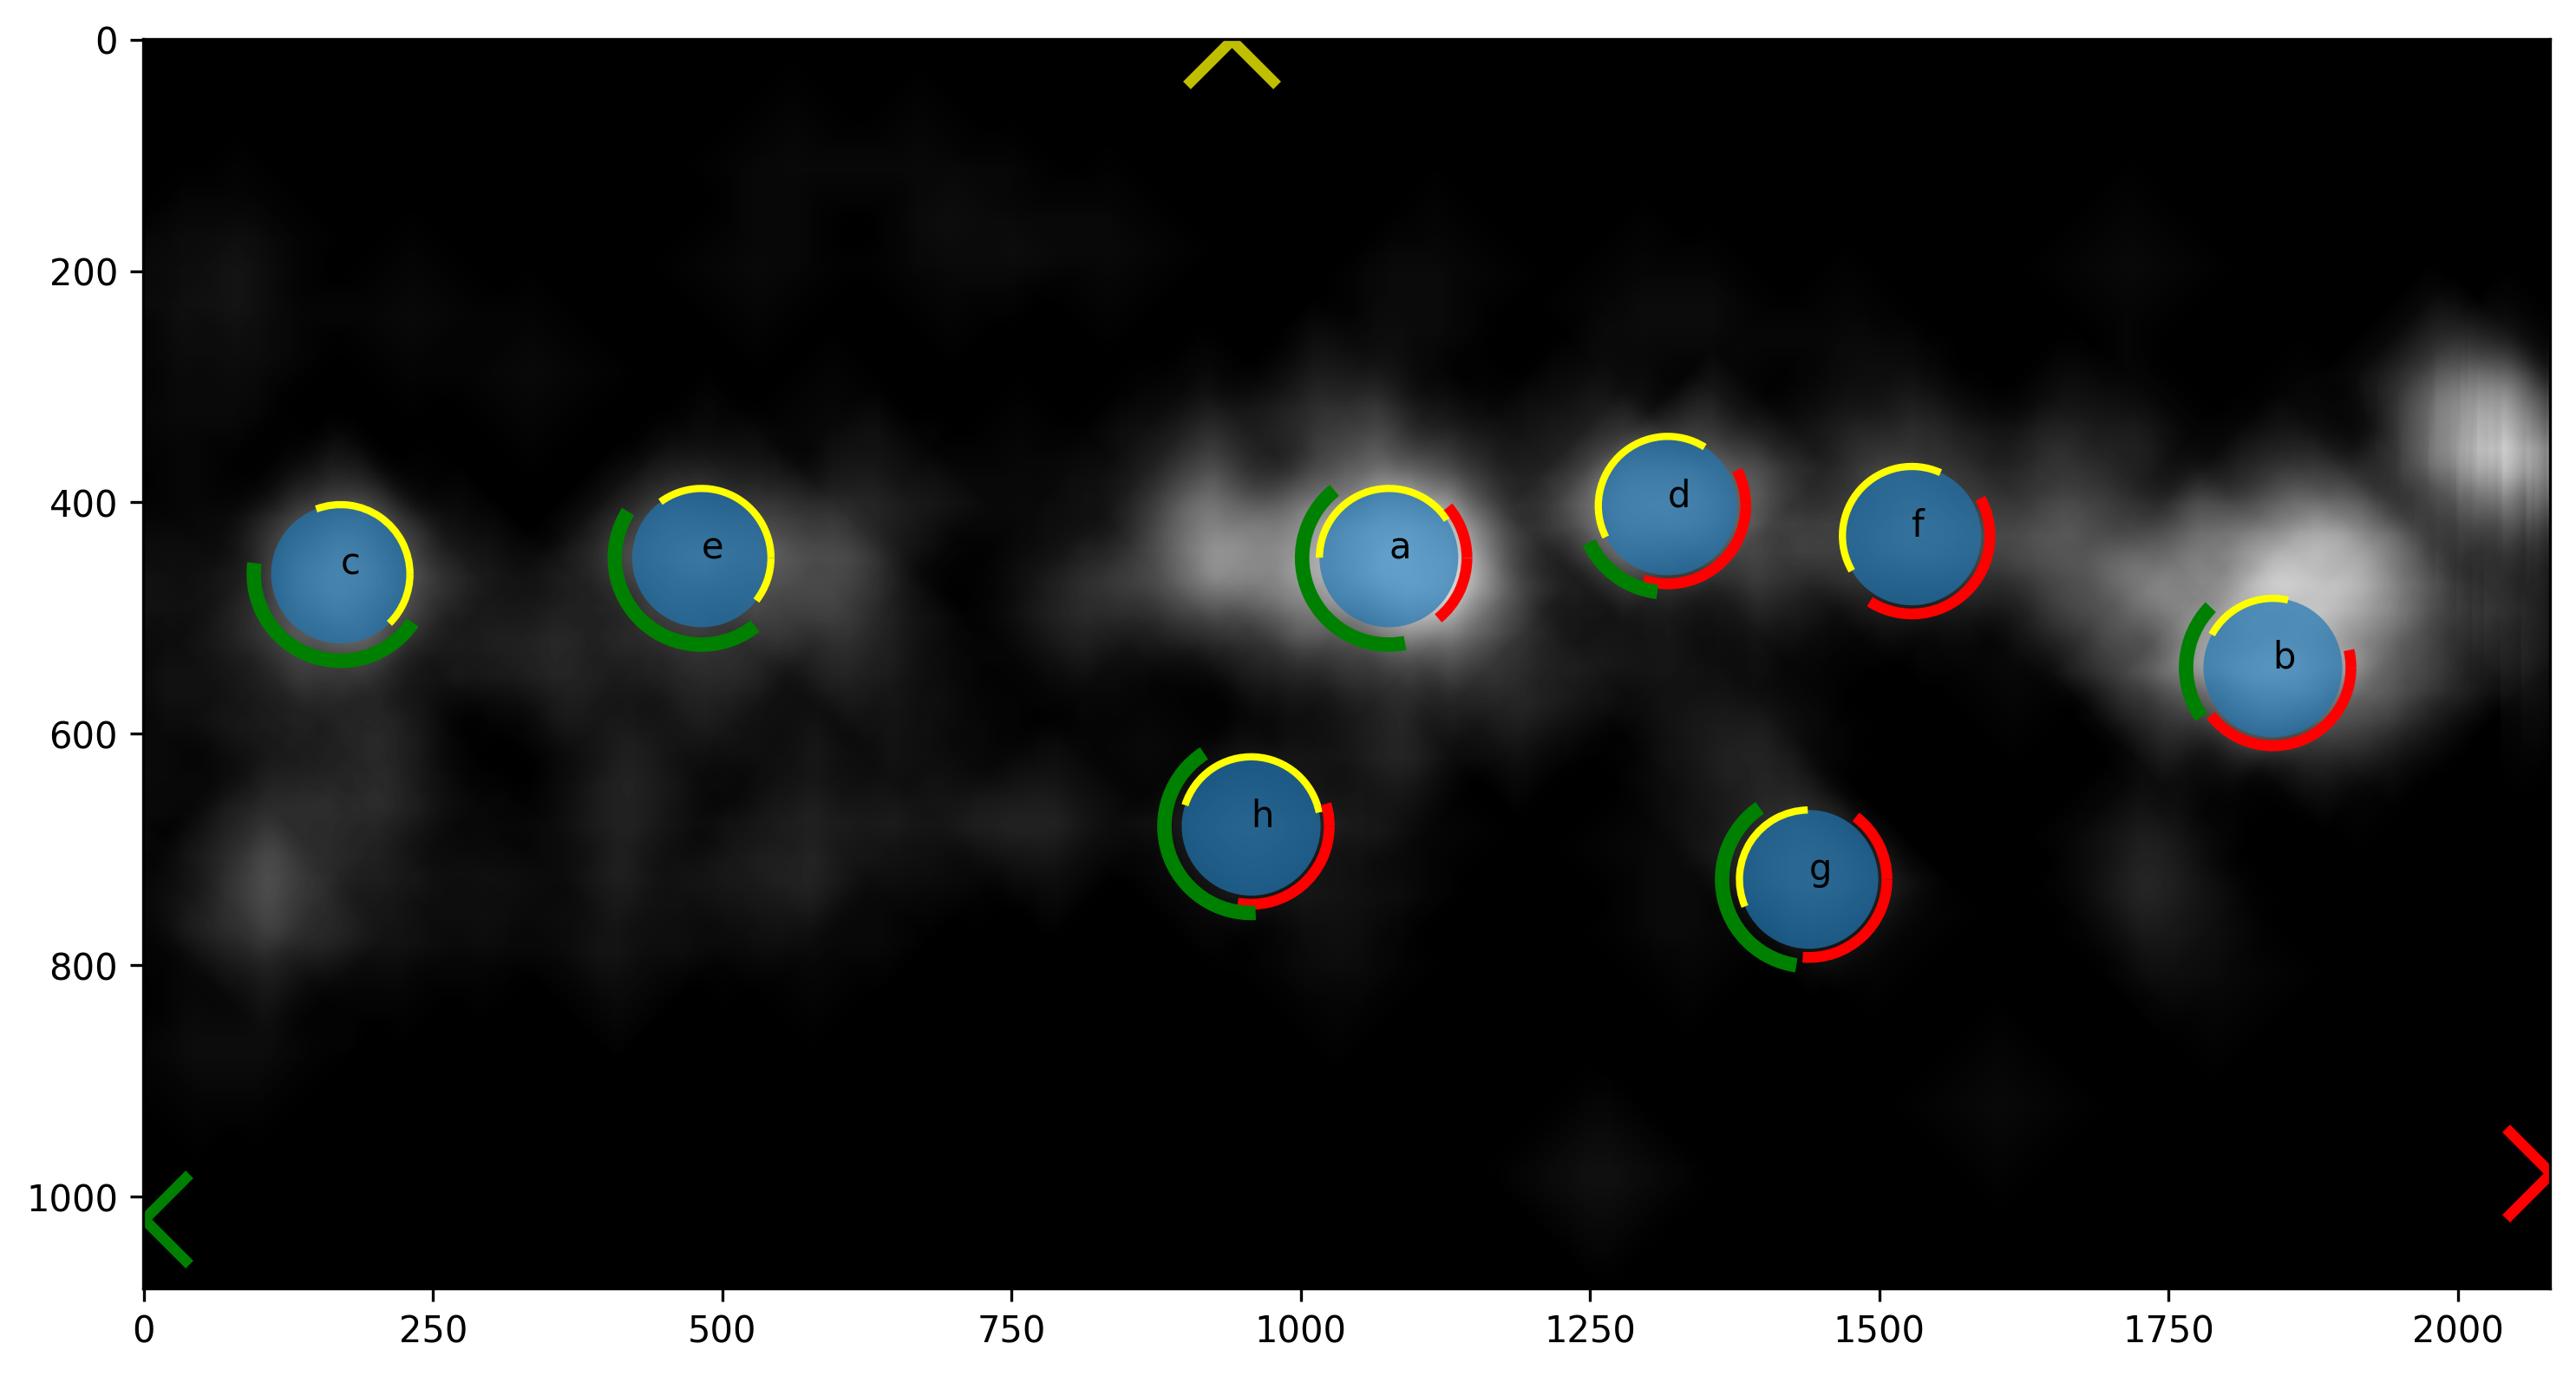

CPU times: user 2h 47min 11s, sys: 50.8 s, total: 2h 48min 1s
Wall time: 15min 14s


In [21]:
%%time
%env RUST_LOG=1

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=NUM_PEAKS)
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2280,
    'pixel_step': 20,
}
res, cov = optimize_v3(*arr.T, LETTERS, **options)
plot_from_optimal_coords(data, peaks, res, cov)

### Sz√°mol√°si r√©szletek

Legyen egy $r$ sugar√∫ k√∂r $O(O_x, O_y)$ k√∂z√©pponttal, tov√°bb√° tekints√ºnk k√©t $P(P_x, P_y)$ pontb√≥l kiindul√≥ sugarat, amelyek $P_1(P_{1x}, P_{1y})$ √©s $P_2(P_{2x}, P_{2y})$ pontokban metszik a k√∂rt (ha t√∂bb metsz√©spont is lehets√©ges, akkor a k√∂zelebbit v√°lasztjuk). Legyen a k√∂r k√∂z√©ppontj√°b√≥l a metsz√©spontokba mutat√≥ k√©t sz√∂g $\alpha_1$ √©s $\alpha_2$ standard x-y koordin√°tarendszerben, amelyek egyszer≈±en sz√°molhat√≥ak az $atan2(P_{iy} - O_y, P_{ix} - O_x)$ formul√°val. 

A szimul√°ci√≥ sor√°n minden k√∂rh√∂z hozz√° van rendelve egy √°llapot, amely t√°rolja, hogy mely sz√∂gtartom√°nyokban van lefedve. Ezek √∂sszefed≈ë r√©szei egy adott szenzor√°ll√°sn√°l egyes√≠t√©sre ker√ºlnek, azt√°n a fennmarad√≥ intervallumok hossz√°t kisz√°molva, majd $2\pi$-vel elosztva megkapjuk, hogy az adott k√∂r h√°nyad r√©sze lefedett, vagyis ez adja a fentebb eml√≠tett $L_i(x)$ f√ºggv√©nyt.